<a href="https://colab.research.google.com/github/GeremiaPompei/ISPR/blob/main/midterm2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ISP Midterm 2 - Assignment 2 - Pompei Geremia (MAT. 638432)

In [ ]:
!rm -rf MSRC_ObjCategImageDatabase_v1
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip msrc_objcategimagedatabase_v1.zip
!rm -rf msrc_objcategimagedatabase_v1.zip

In [2]:
!pip install opencv-contrib-python==4.4.0.44
import cv2
from google.colab.patches import cv2_imshow

from functools import reduce
from random import seed, shuffle, randint

import numpy as np

from os import listdir
from os.path import join

from scipy.cluster import vq

from gensim.models.ldamulticore import LdaModel

%matplotlib inline
import matplotlib.pyplot as plt

     |████████████████████████████████| 55.7 MB 1.3 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


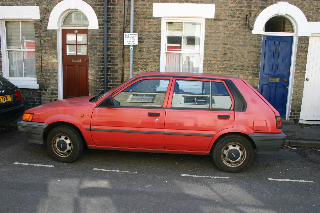

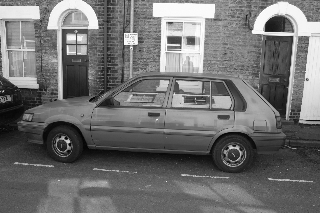

In [3]:
#@title Initial Settings

random_seed =  0#@param {type:"number", min:0}
seed(random_seed)

images_dir = "MSRC_ObjCategImageDatabase_v1"

images_paths = {}
for fn in listdir(images_dir):
  if "_GT" not in fn:
    if fn[0] in images_paths:
      images_paths[fn[0]].append(join(images_dir, fn))
    else:
      images_paths[fn[0]] = [join(images_dir, fn)]
images_paths = list(images_paths.values())

fpath = images_paths[0][0]
img = cv2.imread(fpath)
bw_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

cv2_imshow(img)
cv2_imshow(bw_img)

In [4]:
#@title Image Importing Settings
n_ts_items = 2 #@param {type:"number", min: 0}

TR_paths, TS_paths, = [], []
for images_path in images_paths:
  TR_paths += images_path[:-n_ts_items]
  TS_paths += images_path[-n_ts_items:]

shuffle(TR_paths)

In [5]:
def show(images):
  cv2_imshow(np.concatenate(images, axis=1))

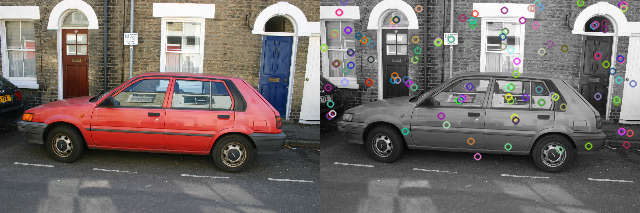

In [6]:
mser = cv2.MSER_create()

kp = mser.detect(img)

kimg = cv2.drawKeypoints(bw_img, kp, img.copy())
show([img, kimg])

In [7]:
sift = cv2.xfeatures2d.SIFT_create()

kp, des = sift.compute(img, kp) 

print(des)

[[ 0.  0.  0. ... 22. 82. 21.]
 [36. 14. 48. ...  0.  0.  0.]
 [ 0.  0.  0. ... 22. 17.  7.]
 ...
 [54. 28. 58. ... 24. 63. 11.]
 [67. 25. 24. ... 21. 38. 15.]
 [46. 19.  3. ...  8. 10. 21.]]


In [8]:
class ImgData:

  def __init__(self, path, kp, des):
    self.path = path
    self.kp = kp
    self.des = des

  @staticmethod
  def create_list_data(paths):
    list_data = []
    for path in paths:
      img = cv2.imread(path)
      if img is not None and len(img) > 0:
        bw_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kp = mser.detect(bw_img)
        kp, des = sift.compute(bw_img, kp)
        list_data.append(ImgData(path, kp, des))
    return list_data

  @staticmethod
  def list_data_to_stack_des(list_data):
    return reduce(lambda x, y: np.vstack((x, y)), 
                  map(lambda x: x.des, 
                      filter(lambda x: x.des is not None, list_data))
                  )

In [9]:
class BOF:

  def __init__(self, imgdata, code, histogram, med):
    self.imgdata = imgdata
    self.code = code
    self.histogram = histogram
    self.med = med

  @staticmethod
  def create_list_bof(list_imgdata, codebook):
    list_bof = []
    for imgdata in list_imgdata:
      if imgdata.des is not None:
        normalized_des = vq.whiten(imgdata.des)
        code, med = vq.vq(normalized_des, codebook)
        histogram, _ = np.histogram(code, bins=range(codebook.shape[0]))
        list_bof.append(BOF(imgdata, code, list(enumerate(histogram)), med))
    return list_bof


In [10]:
#@title K-Means Settings

list_data_train = ImgData.create_list_data(TR_paths)
stack_des = ImgData.list_data_to_stack_des(list_data_train)

n_clusters = 500 #@param {type:"number", min: 1}
normalized_stack = vq.whiten(stack_des)
codebook, med = vq.kmeans(normalized_stack, n_clusters)

list_bof_tr = BOF.create_list_bof(list_data_train, codebook)

print(f"Mean Euclidean Distance: {med}")

/usr/local/lib/python3.7/dist-packages/scipy/cluster/vq.py:139: RuntimeWarning: Some columns have standard deviation zero. The values of these columns will not change.
  RuntimeWarning)


Mean Euclidean Distance: 6.742002010345459


In [11]:
def show_hist_img(list_bof):
  for i, bof in enumerate(list_bof):
    fig, axs = plt.subplots(1, 2)
    axs[0].set_title(bof.imgdata.path)
    axs[0].hist(bof.code, codebook.shape[0])
    axs[1].imshow(cv2.imread(bof.imgdata.path))
    plt.show()

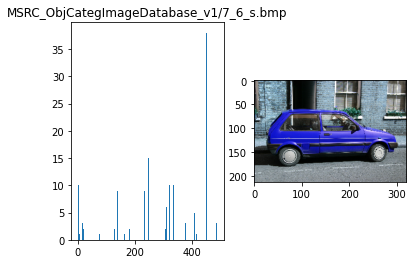

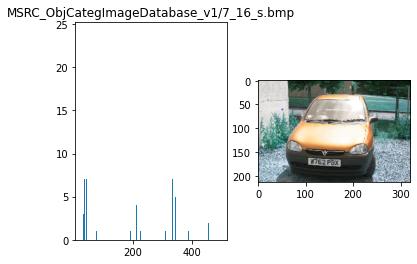

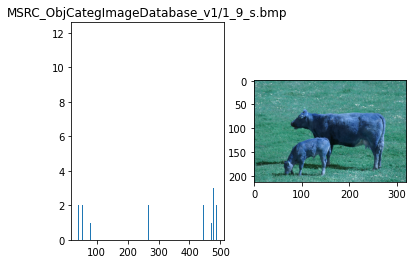

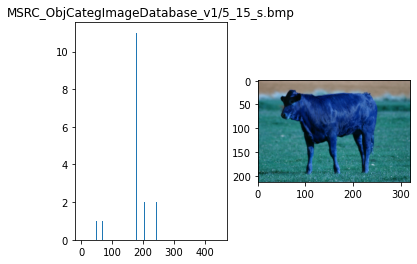

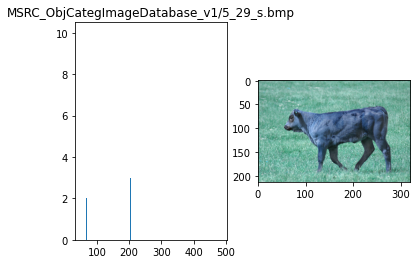

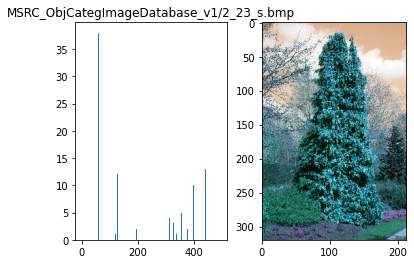

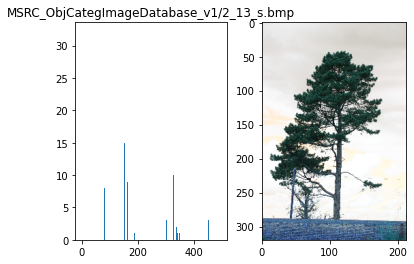

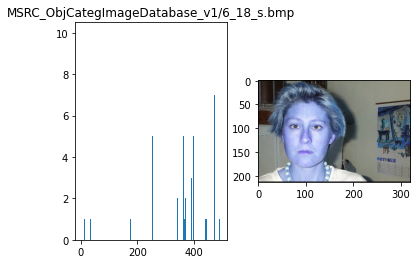

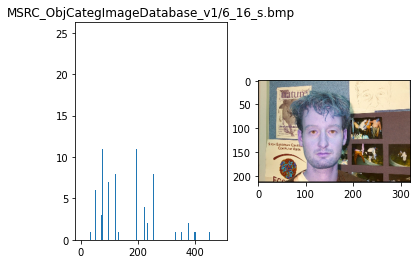

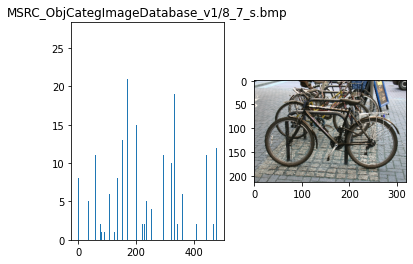

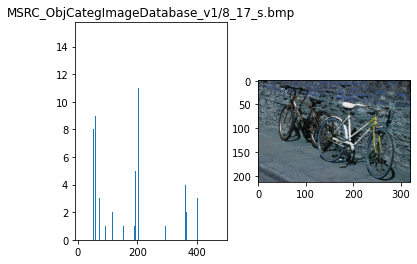

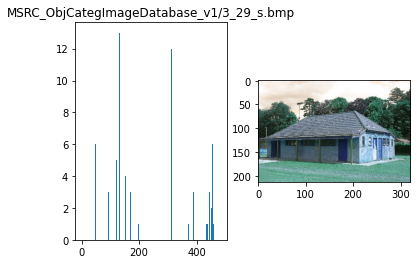

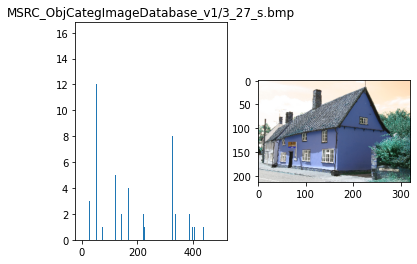

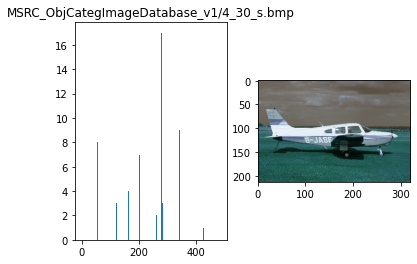

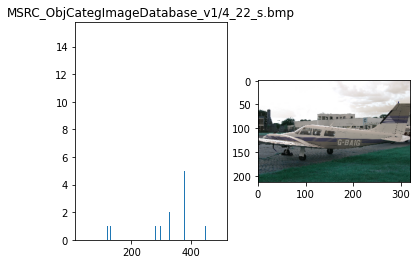

In [12]:
list_data_test = ImgData.create_list_data(TS_paths)

list_bof_ts = BOF.create_list_bof(list_data_test, codebook)

show_hist_img(list_bof_ts)

In [13]:
class Topic:

  def __init__(self, id, text, color):
    self.id = id
    self.text = text
    self.color = color
  
  @staticmethod
  def create_list_topics(n_topics):
    return [Topic(i, f"Topic {i}", (randint(0, 255), randint(0, 255), randint(0, 255))) for i in range(n_topics)]

In [17]:
#@title LDA Settings

n_topics =  12 #@param {type:"slider", min:3, max:50, step:1}
topics = Topic.create_list_topics(n_topics)

unique_histogram = map(lambda bof: bof.histogram, list_bof_tr)
alpha = 0.02 #@param {type:"slider", min:0.01, max:1, step:0.01}
lda = LdaModel(unique_histogram, alpha=alpha, num_topics=len(topics), minimum_probability=0)

lda_triplets = [
          lda.get_document_topics(bof.histogram, per_word_topics=True, minimum_probability=0) 
          for bof 
          in list_bof_ts
          ]
list_feature_topics = [
          feature_topics 
          for img_topics, feature_topics, phi_values 
          in lda_triplets
          ]

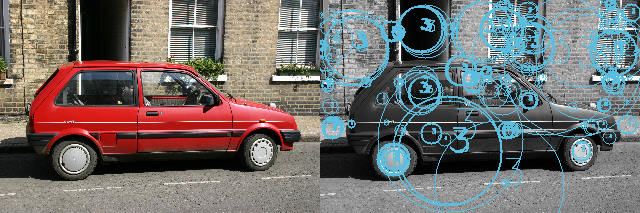

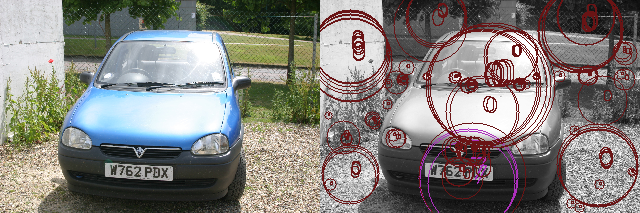

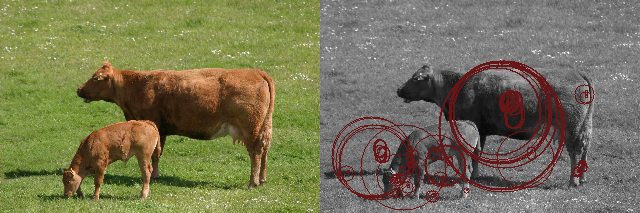

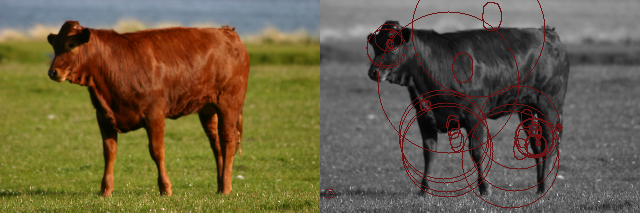

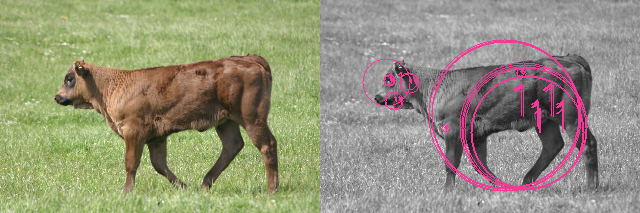

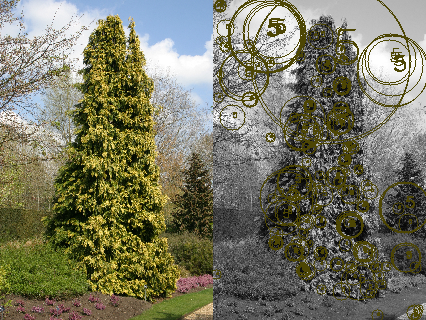

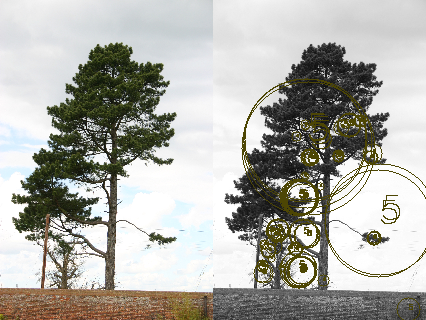

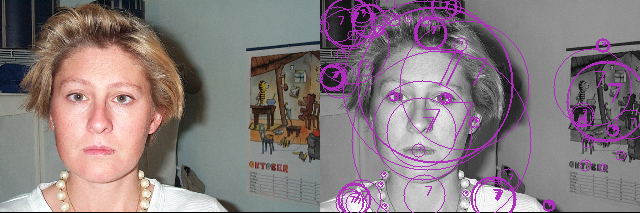

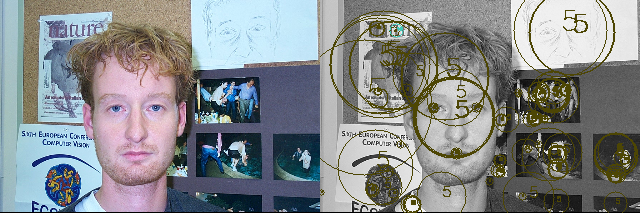

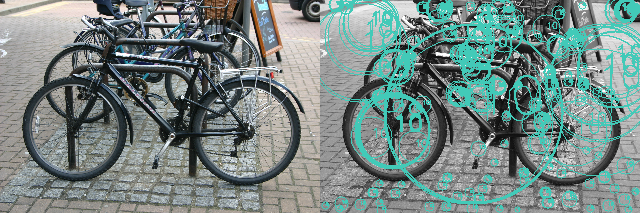

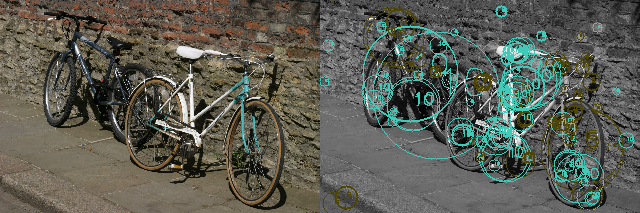

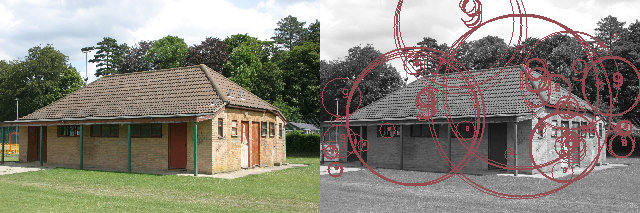

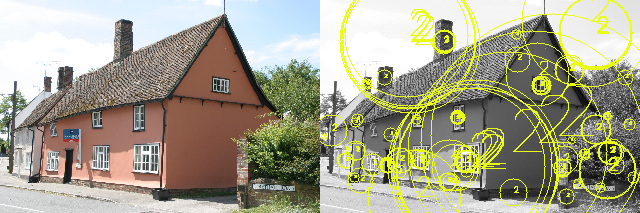

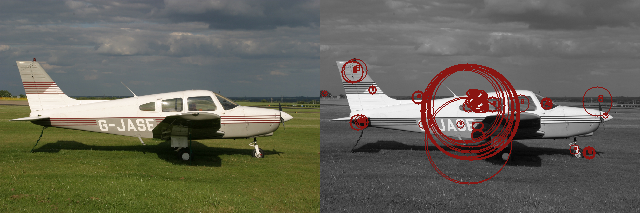

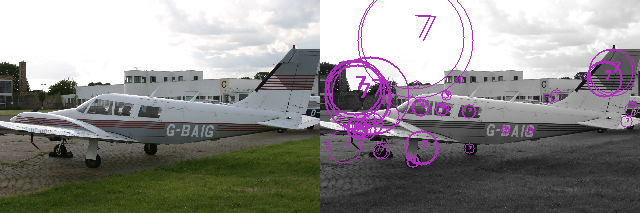

In [18]:
def apply_lda(bof, feature_topics, topics):
  img = cv2.imread(bof.imgdata.path)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  for i, kp in enumerate(bof.imgdata.kp):
    ordered_topic = [feature_topic[1][0] for feature_topic in feature_topics if feature_topic[0] == bof.code[i]]
    if len(ordered_topic) > 0:
      topic = topics[ordered_topic[0]]
      size = int(kp.size/2)
      pos = (int(kp.pt[0]), int(kp.pt[1]))
      img = cv2.circle(img, pos, size, color=topic.color)
      img = cv2.putText(img, str(topic.id), pos, cv2.FONT_HERSHEY_SIMPLEX, size/50, topic.color, 1, 1)
  return img
    
for bof, feature_topics in zip(list_bof_ts, list_feature_topics):
  lda_img = apply_lda(bof, feature_topics, topics)
  show([cv2.imread(bof.imgdata.path), lda_img])